In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
import pickle
import requests
import numpy as np
from glicko2 import Glicko2
from trueskill import TrueSkill
from scipy.stats import norm
from collections import defaultdict
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["figure.titlesize"] = 20

## Load data

In [2]:
df = pd.read_csv('data_preprocessed.csv', parse_dates=['Date'])

In [3]:
df.head()

,Unnamed: 0.1,index,Unnamed: 0,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season,home_win,draw,away_win,winner,loser
0,0,44,44,D1,1993-01-09,werderbremen,duisburg,1,5,A,NaN,NaN,NaN,1993-94,0,0,1,duisburg,werderbremen
1,1,42,42,D1,1993-01-09,m'gladbach,schalke04,3,2,H,NaN,NaN,NaN,1993-94,1,0,0,m'gladbach,schalke04
2,2,41,41,D1,1993-01-09,kaiserslautern,nurnberg,3,1,H,NaN,NaN,NaN,1993-94,1,0,0,kaiserslautern,nurnberg
3,3,40,40,D1,1993-01-09,hamburg,leverkusen,2,1,H,NaN,NaN,NaN,1993-94,1,0,0,hamburg,leverkusen
4,4,39,39,D1,1993-01-09,fckoln,freiburg,2,0,H,NaN,NaN,NaN,1993-94,1,0,0,fckoln,freiburg


In [4]:
# get a dictionary lookup with team id and the day before the team first played. this is the day that we will set the initial rating on

teams = pd.melt(df[['winner', 'loser', 'Date']], value_vars=['winner', 'loser'], id_vars='Date', value_name='team', var_name='status')
all_teams = teams.team.unique()

## Brier Score

In [5]:
# could also use the one in sklearn.metrics
def brier_score(preds: list, outs: list) -> float:
    return np.average((outs - preds) ** 2)

## Glicko-2

#### pseudocode

    for period_name, series in df.groupby(period):
        provisional_ratings = {}
        for team in all_teams:
            - get all matches the team has played in this series
            - if so, rewrite team results in the format taken by algorithm
            - calculate new provisional rating of the team using this series and save it
        after doing this for all teams, the provisional ratings you calculated become the real ratings of the teams

In [6]:
def get_provisional_ratings(period, group, ratings, alg):
    # create the rating for each team after the rating period
    prov_ratings = {}
    # get most recent ratings of each team, or generate default ones
    old_ratings = {}
    for team in all_teams:
        try:
            old_ratings[team] = ratings[team]['rating'][-1]
        except IndexError:
            old_ratings[team] = alg.create_rating()
            
    # now generate the series for the teams
    # each series is a list of tuples (outcome, opponent_rating)
    series = defaultdict(list)
    for row in group.itertuples():
        # temporarily save this rating
        if row.draw:
            series[row.winner].append((0.5, old_ratings[row.loser]))
            series[row.loser].append((0.5, old_ratings[row.winner]))
        else:    
            series[row.winner].append((1, old_ratings[row.loser]))
            series[row.loser].append((0, old_ratings[row.winner]))
    
    # pass the rating before the series and the sereis to the algorithm to get updated rating
    for team in all_teams:
        prov_ratings[team] = alg.rate(old_ratings[team], series[team])
    return prov_ratings

In [7]:
def rate_glicko(alg, series_col_name='Season'):
    # Function to generate Glicko ratings using the dataframe
    # initialize ratings dictionary
    ratings = dict()
    for t in all_teams:
        ratings[t] = {'date': [], 'rating': []}
    for period, group in df.groupby(series_col_name):
        provisional_ratings = get_provisional_ratings(period, group, ratings, alg=glicko)
        for team, r in provisional_ratings.items():
            ratings[team]['rating'].append(r)
            ratings[team]['date'].append(period)
    return ratings

In [8]:
# We initialize the algorithm here and not in the function because we will need it later for win predictions
mu=1500
phi=350
tau=.2
sigma=.06
glicko = Glicko2(mu=mu, phi=phi, tau=tau, sigma=sigma)

# Try using Day, Month, different parameter values... You might need to create new columns first
ratings = rate_glicko(alg=glicko)

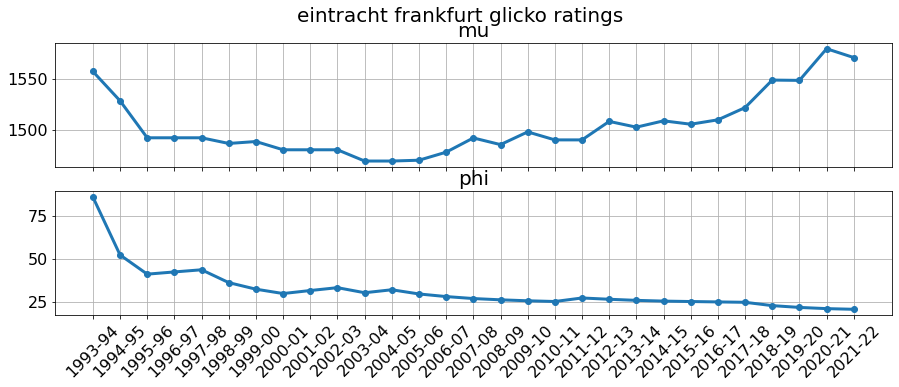

In [9]:
# plotting time: let's look at some teams over time!
fig, ax = plt.subplots(2,1, figsize=(15,5), sharex=True)
ax[0].plot(ratings['einfrankfurt']['date'], [i.mu for i in ratings['einfrankfurt']['rating']], '-o')
ax[0].set_title('mu')
ax[1].plot(ratings['einfrankfurt']['date'], [i.phi for i in ratings['einfrankfurt']['rating']], '-o')
ax[1].set_title('phi')
plt.xticks(rotation=45)
_ = plt.suptitle('eintracht frankfurt glicko ratings')

In [10]:
ratings = rate_glicko(alg=glicko, series_col_name='Date')

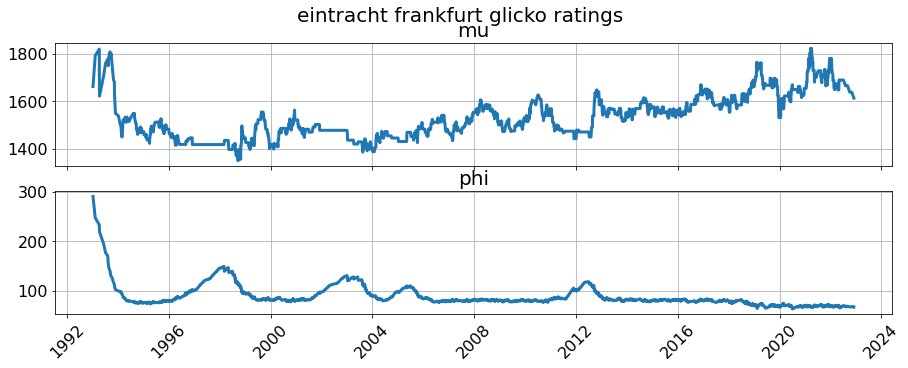

In [11]:
fig, ax = plt.subplots(2,1, figsize=(15,5), sharex=True)
ax[0].plot(ratings['einfrankfurt']['date'], [i.mu for i in ratings['einfrankfurt']['rating']])
ax[0].set_title('mu')
ax[1].plot(ratings['einfrankfurt']['date'], [i.phi for i in ratings['einfrankfurt']['rating']])
ax[1].set_title('phi')
plt.xticks(rotation=45)
_ = plt.suptitle('eintracht frankfurt glicko ratings')

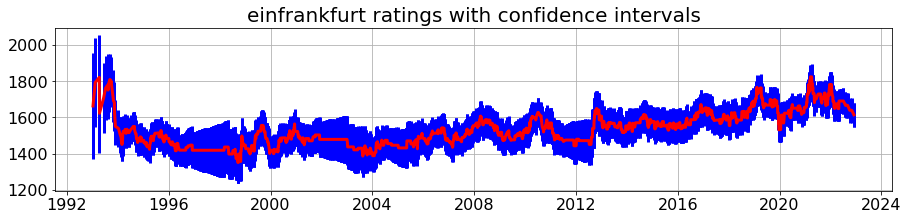

In [12]:
# plot season and day wide glicko
team = 'einfrankfurt'
plt.figure(figsize=(15,3))

#plt.plot(match_dates[team], elo_30_ratings[team][:-1], label='elo 32')
plt.errorbar(ratings[team]['date'], [i.mu for i in ratings[team]['rating']], yerr=[i.phi for i in ratings[team]['rating']], errorevery=1, ecolor='b', color='r')

_ = plt.title(team + ' ratings with confidence intervals')

In [13]:
# which period do you want to use as series? Day, Week, Month...
# remember to have provisional ratings within the rating period and only update the "real rating" after the series end!

## Utility functions

In [23]:
def get_rating_on_date(rating_dict, team, date):
    # todo: how do we manage ratings during calibration period?
    date_idx = rating_dict[team]['date'].index(date)
    if date_idx >= 1:
        return rating_dict[team]['rating'][date_idx - 1]
    else:
        return glicko.create_rating()

In [15]:
# returns the lowest confidence interval mu - 2*RD
def apply_confidence_glicko(glicko_ratings: list) -> np.array:
    skill = []
    for r in glicko_ratings:
        skill.append(r.mu - 2*r.phi)
    return np.array(skill)

## Make predictions

In [20]:
# win predictions - we need to scale down to Glicko 1 and then calculate win probability
def predict_glicko_winner(glicko, r1, r2) -> float:
    r1_g2 = glicko.scale_down(r1)
    r2_g2 = glicko.scale_down(r2)
    # equivalent to calling Glicko2.reduce_impact
    g = 1 / np.sqrt(1+3*r1_g2.phi **2 / np.pi**2)
    # equivalent to calling Glicko2.expect_score
    E = 1 / (1 + np.exp(-g * (r1_g2.mu - r2_g2.mu)))
    return E

In [24]:
glicko_predictions = []
for winner, loser, date in zip(df.winner.values, df.loser.values, df.Date.values):
    winner_rating = get_rating_on_date(ratings, winner, date)
    loser_rating = get_rating_on_date(ratings, loser, date)
    glicko_predictions.append(predict_glicko_winner(glicko, winner_rating, loser_rating))

In [25]:
brier_score(glicko_predictions, np.ones(len(glicko_predictions))-0.5*df.draw)

0.17431796299731783